In [42]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import datetime as dt
import pandas as pd
import numpy as np
import re
import os
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVR
from sklearn import preprocessing
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from numpy import array
from numpy import hstack
from statsmodels.graphics.gofplots import qqplot
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib
%matplotlib inline

## One_Hot_Encode notebook
### Ontario 34 HRs
### Label: Cumulative_deaths test split 0.03
HR |  | 3551 | 3595 | 3553 | 3570 | 3530
--- | --- | --- | --- | --- | --- | ---
HR | Split | ACC | ottawa | toronto | peel | york | durham
Normalized | 0.03 | MSE | 7.04E-07 | 6.45E-06 | 1.23E-06 | 1.03E-07 | 1.04E-06
Normalized | 0.03 | RMSE | 0.00083 | 0.00254 | 0.0011 | 0.00032 | 0.00101
Normalized | 0.2 | MSE | 1.21E-06 | 8.79E-06 | 2.33E-05 | 5.35E-06 | 3.70E-07
Normalized | 0.2 | RMSE | 0.0011 | 0.00296 | 0.00482 | 0.00231 | 0.0006


### Label: Cumulative_cases
HR |  | 3551 | 3595 | 3553 | 3570 | 3530
--- | --- | --- | --- | --- | --- | ---
HR | Split | ACC | ottawa | toronto | peel | york | durham
Normalized | 0.03 | MSE | 3.90E-07 | 1.02E-05 | 1.72E-05 | 2.29E-06 | 4.44E-06
Normalized | 0.03 | RMSE | 0.00062 | 0.00318 | 0.00415 | 0.00151 | 0.0021
Normalized | 0.2 | MSE | 1.09E-06 | 1.93E-05 | 0.00027 | 2.29E-05 | 1.19E-05
Normalized | 0.2 | RMSE | 0.00104 | 0.00439 | 0.01645 | 0.00479 | 0.00345

## Findings
## Modified Below
- from 2020/1/25 ~ 2020/07/14
- Label: Cumulative death has the stable result with the minimum rmse on lstm_90_2
- Label: Cumulative cases has the stable result with the minimum rmse on lstm_90_2

## TWO
- Change train test dataset
- Increase the shape of the input data (multi-step)
- all provinces

## Connect to DB

In [23]:
conn = sqlite3.connect('../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
# ON PRUID 35
df_mob_sort.head()

PRUID HR_UID                       PROV  \
10661    10   1011  Newfoundland and Labrador   
10662    10   1011  Newfoundland and Labrador   
10663    10   1011  Newfoundland and Labrador   
10664    10   1011  Newfoundland and Labrador   
10665    10   1011  Newfoundland and Labrador   

                                 HR_NAME        DATE     Md_PD  Mrr_PD  \
10661  Eastern Regional Health Authority  2020-01-13     0.000     0.0   
10662  Eastern Regional Health Authority  2020-01-14   102.546     0.0   
10663  Eastern Regional Health Authority  2020-01-15   164.430     0.0   
10664  Eastern Regional Health Authority  2020-01-16   185.004     0.0   
10665  Eastern Regional Health Authority  2020-01-17 -1143.882     0.0   

       Mgp_PD     Mp_PD     Mt_PD  ...     Mr_RP      M_RP     Md_MP  Mrr_MP  \
10661     0.0  0.000000  0.000000  ...  0.000000  0.000000   0.00000     0.0   
10662     0.0 -0.004860 -0.009882  ... -0.000098  0.295418   4.76649     0.0   
10663     0.0 -0.009882 -0.019602  ... -0.000199  0.473583   7.64295     0.0   
10664     0.0 -0.014742 -0.029484  ... -0.000298  0.532627   8.59926     0.0   
10665     0.0 -0.019602 -0.039204  ... -0.000396 -3.299628 -53.16933     0.0   

       Mgp_MP     Mp_MP     Mt_MP     Mw_MP     Mr_MP      M_MP  
10661     0.0  0.000000  0.000000  0.000000  0.000000  0.000000  
10662     0.0 -0.000226 -0.000459 -0.003652 -0.000226  0.680275  
10663     0.0 -0.000459 -0.000911 -0.007304 -0.000459  1.090545  
10664     0.0 -0.000685 -0.001370 -0.010956 -0.000685  1.226509  
10665     0.0 -0.000911 -0.001822 -0.014601 -0.000911 -7.598225  

[5 rows x 37 columns]

## data preprocessing

In [24]:
## Run
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
new = df_COVID['HR_UID'].str.split(".", n = 1, expand = True) 
df_COVID['HR_UID']= new[0]
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
# mob_health date '2020-07-05'
max_date = mob_health['DATE'].max()
max_date1 = df_COVID['report_date'].max()
if max_date<max_date1:
    max_dt = max_date
else:
    max_dt= max_date1
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_dt)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
# add label to df
df_risk_label_la = df_risk_label.rename(columns={"cases": "cases_la", "cumulative_cases": "cumulative_cases_la",
                             "deaths":"deaths_la", "cumulative_deaths":"cumulative_deaths_la"})
pd_merge_label = pd.merge(pd_merge_new, df_risk_label_la, on=['report_date', 'HR_UID'], how='left')
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
#     lst.remove(label)
    data = pd_merge_label[lst]

    df_label = pd_merge_label[[label]]
    data_scale = scaler.fit_transform(data)
#     data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
#     df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_label.columns.tolist()) - set(df_data_scale.columns.tolist())- set(df_label.columns.tolist()))
    col_lst.append('PRUID_x')
    pd_feature = pd_merge_label[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, df_label], axis=1)
    return df_merge_model

df_merge_model = label('cumulative_deaths_la')
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index  Perceived_health_good  cases_la PRUID_x        DATE HR_UID  \
0      0                  0.577       0.0      35  2020-01-25   3553   
1      1                  0.577       0.0      35  2020-01-26   3553   
2      2                  0.577       0.0      35  2020-01-27   3553   
3      3                  0.577       0.0      35  2020-01-28   3553   
4      4                  0.577       0.0      35  2020-01-29   3553   

  health_region report_date                    HR_NAME     PROV  ...  \
0          peel  2020-01-25  Peel Regional Health Unit  Ontario  ...   
1          peel  2020-01-26  Peel Regional Health Unit  Ontario  ...   
2          peel  2020-01-27  Peel Regional Health Unit  Ontario  ...   
3          peel  2020-01-28  Peel Regional Health Unit  Ontario  ...   
4          peel  2020-01-29  Peel Regional Health Unit  Ontario  ...   

       M_MP  cases  cumulative_cases  deaths cumulative_deaths  \
0  0.621158    0.0               0.0     0.0               0.0   
1  0.434065    0.0               0.0     0.0               0.0   
2  0.511856    0.0               0.0     0.0               0.0   
3  0.550283    0.0               0.0     0.0               0.0   
4  0.568742    0.0               0.0     0.0               0.0   

   Population_density  ambulatory  hospitals  nursing_residential  \
0            0.255652         1.0   0.714286                  1.0   
1            0.255652         1.0   0.714286                  1.0   
2            0.255652         1.0   0.714286                  1.0   
3            0.255652         1.0   0.714286                  1.0   
4            0.255652         1.0   0.714286                  1.0   

   cumulative_deaths_la  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 56 columns]

## Model Input for Multiple Input Series
-  first dimension is the number of samples
-  second dimension is the number of time steps per sample
-  the last dimension specifies the number of parallel time series or the number of variables

## Multivariate model
- label: Cum_deaths
    - lag features: 7 days
- label: Cum_cases
    - lag features: 14 days
    
- ON
    - 34 pandemic hubs
- approach
    - first
    - get independent HR df and train test split by 0.97 and 0.03, (by time-series factor), take time into account
    - concat array for X_train, and X_test


In [67]:
## Run
## change label: df_merge_model = label('cumulative_cases')
## process data
conn = sqlite3.connect('../data/hubs.db')
df_mob = pd.read_sql_query("SELECT * from Mobility_HR_V", conn)
df_mob_sort = df_mob.sort_values(by=['HR_UID','DATE'])
df_health = pd.read_sql_query("SELECT * from Health_Indicators_ODHF", conn)
df_health1 = df_health[['HR_UID','Population_density', 'ambulatory','hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']]
mob_health = pd.merge(df_mob, df_health1, how='left', on=['HR_UID'])
df_COVID = pd.read_sql_query("SELECT * from Covid19", conn)
# total cols of 2 dataframe merged
new = df_COVID['HR_UID'].str.split(".", n = 1, expand = True) 
df_COVID['HR_UID']= new[0]
pd_merge = pd.merge(mob_health, df_COVID, how='right', left_on=['DATE', 'HR_UID'], right_on=['report_date', 'HR_UID'])
# mob_health date '2020-07-05'
max_date = mob_health['DATE'].max()
max_date1 = df_COVID['report_date'].max()
if max_date<max_date1:
    max_dt = max_date
else:
    max_dt= max_date1
pd_merge_new = pd_merge.loc[(pd_merge['DATE']>='2020-01-25') & (pd_merge['DATE']<=max_dt)]
# dropping duplicte values on same HR_UID and Date
pd_merge_new.drop_duplicates(subset =["HR_UID", "DATE"], inplace = True) 
# add label to df
df_risk_label = pd.read_sql_query("SELECT * from HIGH_RISK_6", conn)
df_risk_label_la = df_risk_label.rename(columns={"cases": "cases_la", "cumulative_cases": "cumulative_cases_la",
                             "deaths":"deaths_la", "cumulative_deaths":"cumulative_deaths_la"})
pd_merge_label = pd.merge(pd_merge_new, df_risk_label_la, on=['report_date', 'HR_UID'], how='left')
# minmax scaler
scaler = MinMaxScaler()
# minmax scaler
scaler1 = MinMaxScaler()
# add and remove cumulative_deaths, cumulative_cases
def label(label):
    lst = ['Md_PD', 'Mrr_PD',
        'Mgp_PD', 'Mp_PD', 'Mt_PD', 'Mw_PD', 'Mr_PD', 'M_PD', 'Md_MD',
        'Mrr_MD', 'Mgp_MD', 'Mp_MD', 'Mt_MD', 'Mw_MD', 'Mr_MD', 'M_MD','Md_RP', 'Mrr_RP',
       'Mgp_RP', 'Mp_RP', 'Mt_RP', 'Mw_RP', 'Mr_RP', 'M_RP', 'Md_MP', 'Mrr_MP',
       'Mgp_MP', 'Mp_MP', 'Mt_MP', 'Mw_MP', 'Mr_MP', 'M_MP','cases', 'cumulative_cases', 'deaths',
       'cumulative_deaths', 'Population_density','ambulatory','hospitals','nursing_residential']
#     lst.remove(label)
    data = pd_merge_label[lst]

    df_label = pd_merge_label[[label]]
    data_scale = scaler.fit_transform(data)
#     data_scale1 = scaler1.fit_transform(data1)
    df_data_scale = pd.DataFrame(data=data_scale,columns=lst)
#     df_data_scale1 = pd.DataFrame(data=data_scale1,columns=[label])
    col_lst = list(set(pd_merge_label.columns.tolist()) - set(df_data_scale.columns.tolist())- set(df_label.columns.tolist()))
    col_lst.append('PRUID_x')
    pd_feature = pd_merge_label[col_lst]
    pd_feature.reset_index(inplace=True)
    df_merge_model = pd.concat([pd_feature, df_data_scale, df_label], axis=1)
    return df_merge_model

df_merge_model = label('cumulative_deaths_la')
df_merge_model.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


index  Perceived_health_good  cases_la PRUID_x        DATE HR_UID  \
0      0                  0.577       0.0      35  2020-01-25   3553   
1      1                  0.577       0.0      35  2020-01-26   3553   
2      2                  0.577       0.0      35  2020-01-27   3553   
3      3                  0.577       0.0      35  2020-01-28   3553   
4      4                  0.577       0.0      35  2020-01-29   3553   

  health_region report_date                    HR_NAME     PROV  ...  \
0          peel  2020-01-25  Peel Regional Health Unit  Ontario  ...   
1          peel  2020-01-26  Peel Regional Health Unit  Ontario  ...   
2          peel  2020-01-27  Peel Regional Health Unit  Ontario  ...   
3          peel  2020-01-28  Peel Regional Health Unit  Ontario  ...   
4          peel  2020-01-29  Peel Regional Health Unit  Ontario  ...   

       M_MP  cases  cumulative_cases  deaths cumulative_deaths  \
0  0.621158    0.0               0.0     0.0               0.0   
1  0.434065    0.0               0.0     0.0               0.0   
2  0.511856    0.0               0.0     0.0               0.0   
3  0.550283    0.0               0.0     0.0               0.0   
4  0.568742    0.0               0.0     0.0               0.0   

   Population_density  ambulatory  hospitals  nursing_residential  \
0            0.255652         1.0   0.714286                  1.0   
1            0.255652         1.0   0.714286                  1.0   
2            0.255652         1.0   0.714286                  1.0   
3            0.255652         1.0   0.714286                  1.0   
4            0.255652         1.0   0.714286                  1.0   

   cumulative_deaths_la  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  

[5 rows x 56 columns]

In [70]:
## Run
## change the label df_label = df_hr[['cumulative_cases_x']]
## change time_lag features
# # shift the value upward
df_merge_model['report_date'] = pd.to_datetime(df_merge_model['report_date'])
# df1 = df.set_index('DATE')
df_new = df_merge_model[['HR_UID', 'report_date','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP', 'report_date']]

def shift_df(lst, lag_date):
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            val = -lag_date_run
            df_new[col_name] = df_new.groupby(['HR_UID'])[a].shift(val)
    return df_new

df_new1 = shift_df(['HR_UID','cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP'],5)
# remove null row
df_new1.dropna(inplace=True)
# drop duplicated columns
df_new2 = df_new1.loc[:,~df_new1.columns.duplicated()]

## Merge df back with health indicator
df_new3 = pd.merge(df_merge_model, df_new2, how='left', on=['HR_UID','report_date'])
# remove null row
df_new3.dropna(inplace=True)
# drop duplicated columns
df_new4 = df_new3.loc[:,~df_new3.columns.duplicated()]
df_on = df_new4.loc[df_new4['PRUID_x']==str(35)]
df_dum_HR = pd.get_dummies(df_on.HR_UID, prefix='HR_UID')
df_on_dum = pd.concat([df_on, df_dum_HR], axis=1)

# select one hr
def df_filter(hr, case, lag_date):
    df_hr = df_on_dum.loc[df_on_dum['HR_UID']==str(hr)]
    # list for input lagged features
    lst = ['cumulative_deaths', 'cumulative_cases', 'cases', 'deaths', 'Mt_RP', 'Mt_MP', 'Mw_MD', 'Mgp_RP']
    col_lst = []
    for date in range(0, lag_date):
        lag_date_run = date+1
        for a in lst:
            col_name = a + str('_-'+str(lag_date_run))
            col_lst.append(col_name)
            
    lst1 = ['Mt_RP_x', 'Mt_MP_x', 'Mw_MD_x', 'Mgp_RP_x', 'Population_density','ambulatory',
               'hospitals','nursing_residential', 'Perceived_health_good', 'Perceived_health_poor']
    col_lst+=lst1
    col_lst+=df_dum_HR.columns.tolist()
    
    if case:
        col_lst.append('cases_x')
    df_feature = df_hr[col_lst]
    df_label = df_hr[['cumulative_deaths_la']]
    # drop duplicated columns
    df_hr1 = df_hr.loc[:,~df_hr.columns.duplicated()]
   
    return df_feature, df_label, df_hr1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [28]:
## Run
X_train_lst = []
X_test_lst = []
y_train_lst = []
y_test_lst = []

for hr in df_on['HR_UID'].unique().tolist():
    
    df_feature, df_label, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
    
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    X_train_lst.append(X_train)
    X_test_lst.append(X_test)
    y_train_lst.append(y_train)
    y_test_lst.append(y_test)
    # X_train shape ((138, 68))

X_train = np.concatenate(X_train_lst, axis=0)
X_test = np.concatenate(X_test_lst, axis=0)
y_train = np.concatenate(y_train_lst, axis=0)
y_test = np.concatenate(y_test_lst, axis=0)
Y_train = y_train.reshape(-1,)
Y_test = y_test.reshape(-1,)


In [30]:
## Run
n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.reshape(n_step, -1,n_features)
x_test = X_test.reshape(X_test.shape[0], -1,X_test.shape[-1])

x_train.shape
# (108, 1,  11)

(4522, 1, 85)

In [31]:
def lstm(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

In [32]:
def lstm_2layer(x_train, Y_train, X_test, y_test, n_step, n_features, input_LSTM):
    model = Sequential()
    model.add(LSTM(input_LSTM, activation='relu', input_shape=(n_step, n_features), return_sequences=True))
    model.add(LSTM(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    # fit model
    history =model.fit(x_train, Y_train, epochs=50, verbose=2, validation_data=(X_test, y_test))
    return history, model

## HR: Ontario Health Unit
- PRUID_x = 35

In [33]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 4522 samples, validate on 1156 samples
Epoch 1/50
 - 3s - loss: 0.2010 - accuracy: 0.9653 - val_loss: 0.0165 - val_accuracy: 1.0000
Epoch 2/50
 - 1s - loss: 0.1021 - accuracy: 0.9653 - val_loss: 0.0297 - val_accuracy: 1.0000
Epoch 3/50
 - 1s - loss: 0.0830 - accuracy: 0.9653 - val_loss: 0.0335 - val_accuracy: 1.0000
Epoch 4/50
 - 1s - loss: 0.0756 - accuracy: 0.9653 - val_loss: 0.0250 - val_accuracy: 1.0000
Epoch 5/50
 - 1s - loss: 0.0737 - accuracy: 0.9664 - val_loss: 0.0213 - val_accuracy: 1.0000
Epoch 6/50
 - 1s - loss: 0.0723 - accuracy: 0.9668 - val_loss: 0.0218 - val_accuracy: 1.0000
Epoch 7/50
 - 1s - loss: 0.0713 - accuracy: 0.9679 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 8/50
 - 1s - loss: 0.0709 - accuracy: 0.9706 - val_loss: 0.0205 - val_accuracy: 1.0000
Epoch 9/50
 - 1s - loss: 0.0704 - accuracy: 0.9713 - val_loss: 0.0184 - val_accuracy: 1.0000
Epoch 10/50
 - 1s - loss: 0.0696 - accuracy: 0.9695 - val_loss: 0.0332 - val_accuracy: 1.0000
Epoch 11/50
 - 1s - l

## Two layer history data

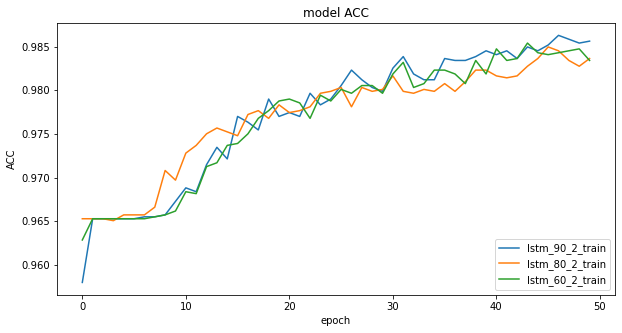

In [37]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))

# plt.plot(history_90.history['accuracy'])
# plt.plot(history_80.history['accuracy'])
# plt.plot(history_60.history['accuracy'])
# plt.plot(history_50.history['accuracy'])
plt.plot(history_90_2.history['accuracy'])
plt.plot(history_80_2.history['accuracy'])
plt.plot(history_60_2.history['accuracy'])

# plt.plot(history.history['val_mae'])
plt.title('model ACC')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='lower right')
# plt.legend(['lstm_90_train', 'lstm_80_train', 'lstm_60_train','lstm_50_train','lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

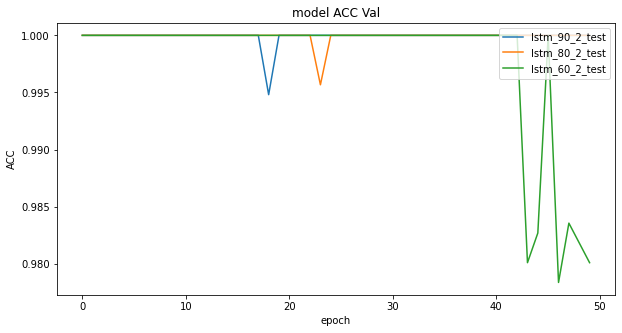

In [38]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90_2.history['val_accuracy'])
plt.plot(history_80_2.history['val_accuracy'])
plt.plot(history_60_2.history['val_accuracy'])

# plt.plot(history.history['val_mae'])
plt.title('model ACC Val')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_test', 'lstm_80_2_test', 'lstm_60_2_test'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

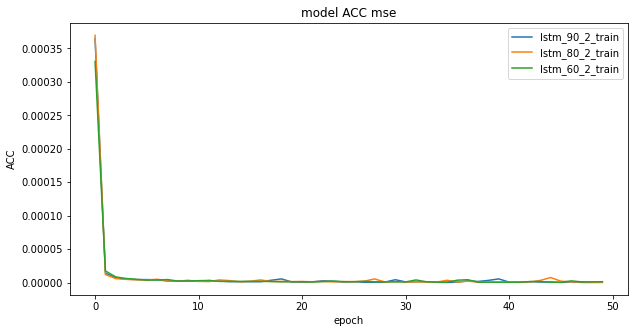

In [271]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90_2.history['mse'])
plt.plot(history_80_2.history['mse'])
plt.plot(history_60_2.history['mse'])

# plt.plot(history.history['val_mae'])
plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

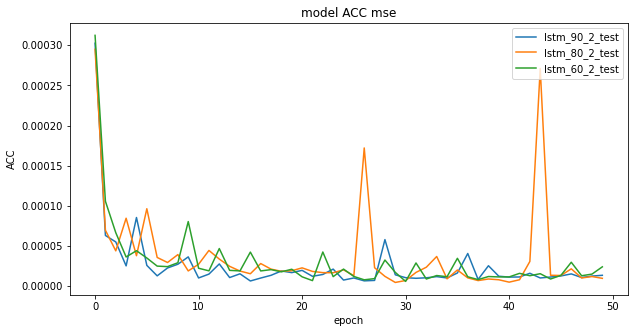

In [272]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90_2.history['val_mse'])
plt.plot(history_80_2.history['val_mse'])
plt.plot(history_60_2.history['val_mse'])

# plt.plot(history.history['val_mae'])
plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_test', 'lstm_80_2_test', 'lstm_60_2_test'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

## Output the best LSTM for ON Health Units
- Label: Cumulative death
- Lots of LSTM models have max ACC, get the most frquent max PRobab pred model
    - ALL LSTM model model predict the all classes

In [65]:
## Run
## Get the best model output
max_lstm_lst = []

for hr in df_on['HR_UID'].unique().tolist():
    
    df_feature, df_label, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
    
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    n_sample = 1
    n_step = X_train.shape[0]
    n_features = X_train.shape[-1]
    x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
    x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])
    
    prediction_90 = model_90.predict_classes(x_test).flatten()
    prediction_80 = model_80.predict_classes(x_test).flatten()
    prediction_60 = model_60.predict_classes(x_test).flatten()
    prediction_90_2 = model_90_2.predict_classes(x_test).flatten()
    prediction_80_2 = model_80_2.predict_classes(x_test).flatten()
    prediction_60_2 = model_60_2.predict_classes(x_test).flatten()
    
    prediction_90 = prediction_90.reshape(-1, 1)
    prediction_80 = prediction_80.reshape(-1, 1)
    prediction_60 = prediction_60.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    prediction_80_2 = prediction_80_2.reshape(-1, 1)
    prediction_60_2 = prediction_60_2.reshape(-1, 1)
#     print(prediction_90_2)
    # accuracy: (tp + tn) / (p + n)
    accuracy_90 = accuracy_score(prediction_90, Y_test)
#     lstm90_lst.append(accuracy_90)
    accuracy_80 = accuracy_score(prediction_80, Y_test)
#     lstm80_lst.append(accuracy_80)
    accuracy_60 = accuracy_score(prediction_60, Y_test)
#     lstm60_lst.append(accuracy_60)
    accuracy_90_2 = accuracy_score(prediction_90_2, Y_test)
#     lstm902_lst.append(accuracy_90_2)
    accuracy_80_2 = accuracy_score(prediction_80_2, Y_test)
#     lstm802_lst.append(accuracy_80_2)
    accuracy_60_2 = accuracy_score(prediction_60_2, Y_test)
#     lstm602_lst.append(accuracy_60_2)
    
    result_dict = {}
    result_dict['ACC 60'] = accuracy_60
    result_dict['ACC 80'] = accuracy_80
    result_dict['ACC 90'] = accuracy_90
    result_dict['ACC 60_2'] = accuracy_60_2
    result_dict['ACC 80_2'] = accuracy_80_2
    result_dict['ACC 90_2'] = accuracy_90_2
    
    max_ACC = max(result_dict, key=result_dict.get)
    max_lstm_lst.append(max_ACC)
#     print(result_dict)
#     print(max_ACC)
#     print('Accuracy: %f' % accuracy)
#     # precision tp / (tp + fp)
#     precision = precision_score(prediction_90_2, Y_test, average='weighted', labels=np.unique(prediction_90_2))
#     print('Precision: %f' % precision)
#     # recall: tp / (tp + fn)
#     recall = recall_score(prediction_90_2, Y_test, average='weighted', labels=np.unique(prediction_90_2))
#     print('Recall: %f' % recall)
#     # f1: 2 tp / (2 tp + fp + fn)
#     f1 = f1_score(prediction_90_2, Y_test, average='weighted', labels=np.unique(prediction_90_2))
#     print('F1 score: %f' % f1)

def most_frequent(List): 
    counter = 0
    num = List[0] 

    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 

    return num 

    
print('The max ACC from lstm model:',most_frequent(max_lstm_lst))


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [52]:
## Run
## Get the best model output
max_lstm_lst = []
lstm90_lst = []
lstm80_lst = []
lstm60_lst = []
lstm902_lst = []
lstm802_lst = []
lstm602_lst = []

for hr in df_on['HR_UID'].unique().tolist():
    
    df_feature, df_label, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)
    
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    n_sample = 1
    n_step = X_train.shape[0]
    n_features = X_train.shape[-1]
    x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
    x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])
    
    prediction_90 = model_90.predict_classes(x_test).flatten()
    prediction_80 = model_80.predict_classes(x_test).flatten()
    prediction_60 = model_60.predict_classes(x_test).flatten()
    prediction_90_2 = model_90_2.predict_classes(x_test).flatten()
    prediction_80_2 = model_80_2.predict_classes(x_test).flatten()
    prediction_60_2 = model_60_2.predict_classes(x_test).flatten()
    
    prediction_90 = prediction_90.reshape(-1, 1)
    prediction_80 = prediction_80.reshape(-1, 1)
    prediction_60 = prediction_60.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    prediction_80_2 = prediction_80_2.reshape(-1, 1)
    prediction_60_2 = prediction_60_2.reshape(-1, 1)
#     print(prediction_90_2)
    # accuracy: (tp + tn) / (p + n)
    accuracy_90 = accuracy_score(prediction_90, Y_test)
#     lstm90_lst.append(accuracy_90)
    accuracy_80 = accuracy_score(prediction_80, Y_test)
#     lstm80_lst.append(accuracy_80)
    accuracy_60 = accuracy_score(prediction_60, Y_test)
#     lstm60_lst.append(accuracy_60)
    accuracy_90_2 = accuracy_score(prediction_90_2, Y_test)
#     lstm902_lst.append(accuracy_90_2)
    accuracy_80_2 = accuracy_score(prediction_80_2, Y_test)
#     lstm802_lst.append(accuracy_80_2)
    accuracy_60_2 = accuracy_score(prediction_60_2, Y_test)
#     lstm602_lst.append(accuracy_60_2)
    
    lstm90_lst.append(accuracy_90)
    lstm80_lst.append(accuracy_80)
    lstm60_lst.append(accuracy_60)
    lstm902_lst.append(accuracy_90_2)
    lstm802_lst.append(accuracy_80_2)
    lstm602_lst.append(accuracy_80_2)
    
#     max_ACC = max(result_dict, key=result_dict.get)
#     max_lstm_lst.append(max_ACC)
#     print(result_dict)
#     print(max_ACC)
#     print('Accuracy: %f' % accuracy)
#     # precision tp / (tp + fp)
#     precision = precision_score(prediction_90_2, Y_test, average='weighted', labels=np.unique(prediction_90_2))
#     print('Precision: %f' % precision)
#     # recall: tp / (tp + fn)
#     recall = recall_score(prediction_90_2, Y_test, average='weighted', labels=np.unique(prediction_90_2))
#     print('Recall: %f' % recall)
#     # f1: 2 tp / (2 tp + fp + fn)
#     f1 = f1_score(prediction_90_2, Y_test, average='weighted', labels=np.unique(prediction_90_2))
#     print('F1 score: %f' % f1)

def most_frequent(List): 
    counter = 0
    num = List[0] 

    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 

    return num 

    
# print('The max ACC from lstm model:',most_frequent(max_lstm_lst))
print('lstm 90:', lstm90_lst)
print('lstm 80:', lstm80_lst)
print('lstm 60:', lstm60_lst)
print('lstm 902:', lstm902_lst)
print('lstm 802:', lstm802_lst)
print('lstm 602:', lstm602_lst)


lstm 90: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
lstm 80: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
lstm 60: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
lstm 902: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
lstm 802: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
lstm 602: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

## Top 5 pandemic hubs on label cumulative deaths of actual vs predicted val on test set

## Test split on 20% data
 - Start_date: MAy/30
 - End_date: 6/29

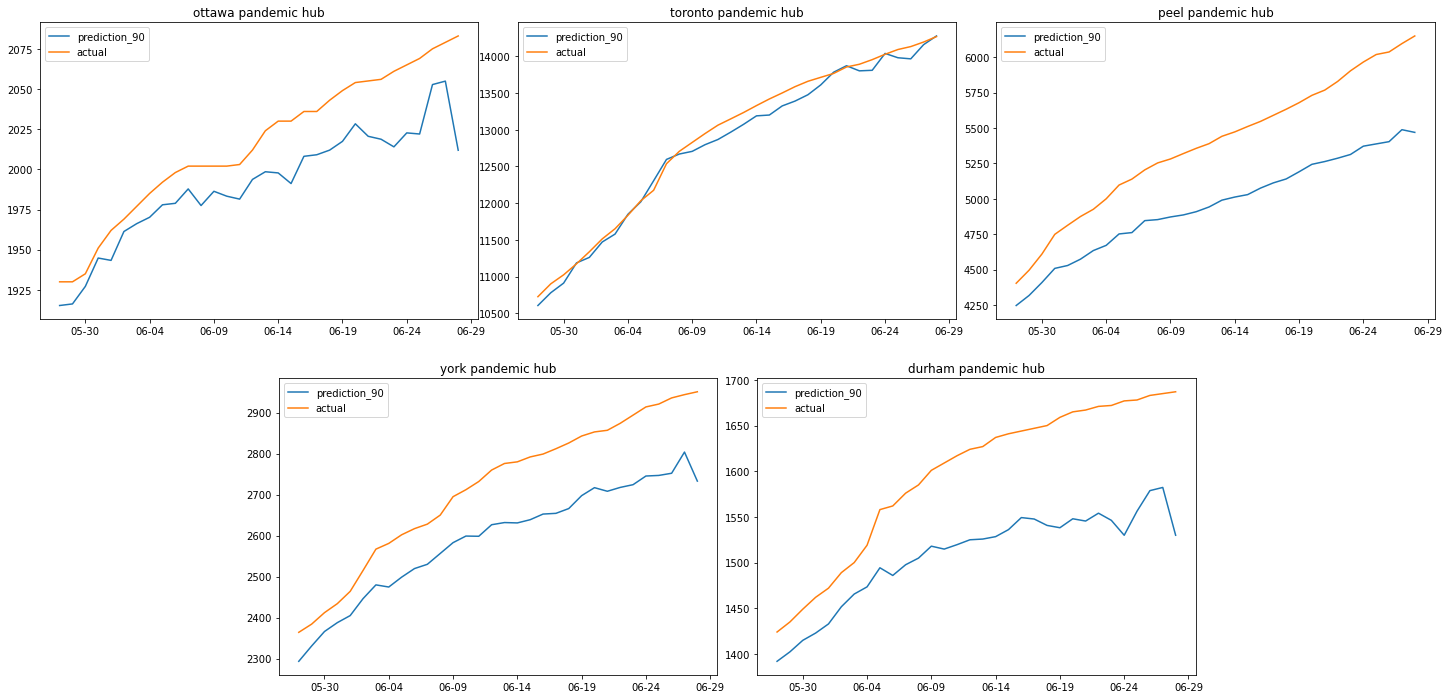

In [274]:

def hr_plot(hr):    
    df_feature, df_label, df_hr1 = df_filter(hr, True,5)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    n_sample = 1
    n_step = X_train.shape[0]
    n_features = X_train.shape[-1]
    x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
    x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(x_test)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90 = model_90.predict(x_test).flatten()
    
    y_test = Y_test.reshape(-1, 1)
    prediction_90 = prediction_90.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90 = scaler1.inverse_transform(prediction_90)
    
    return days, test_inv, inv_90
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90 = hr_plot('3551')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90)
plt.plot(days,test_inv)
plt.title('ottawa pandemic hub')
plt.legend(['prediction_90', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90 = hr_plot('3595')
plt.plot(days,inv_90)
plt.plot(days,test_inv)
plt.title('toronto pandemic hub')
plt.legend(['prediction_90', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90 = hr_plot('3553')
plt.plot(days,inv_90)
plt.plot(days,test_inv)
plt.title('peel pandemic hub')
plt.legend(['prediction_90', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90 = hr_plot('3570')
plt.plot(days,inv_90)
plt.plot(days,test_inv)
plt.title('york pandemic hub')
plt.legend(['prediction_90', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90 = hr_plot('3530')
plt.plot(days,inv_90)
plt.plot(days,test_inv)
plt.title('durham pandemic hub')
plt.legend(['prediction_90', 'actual'])
    
    

## Test split on 3% data

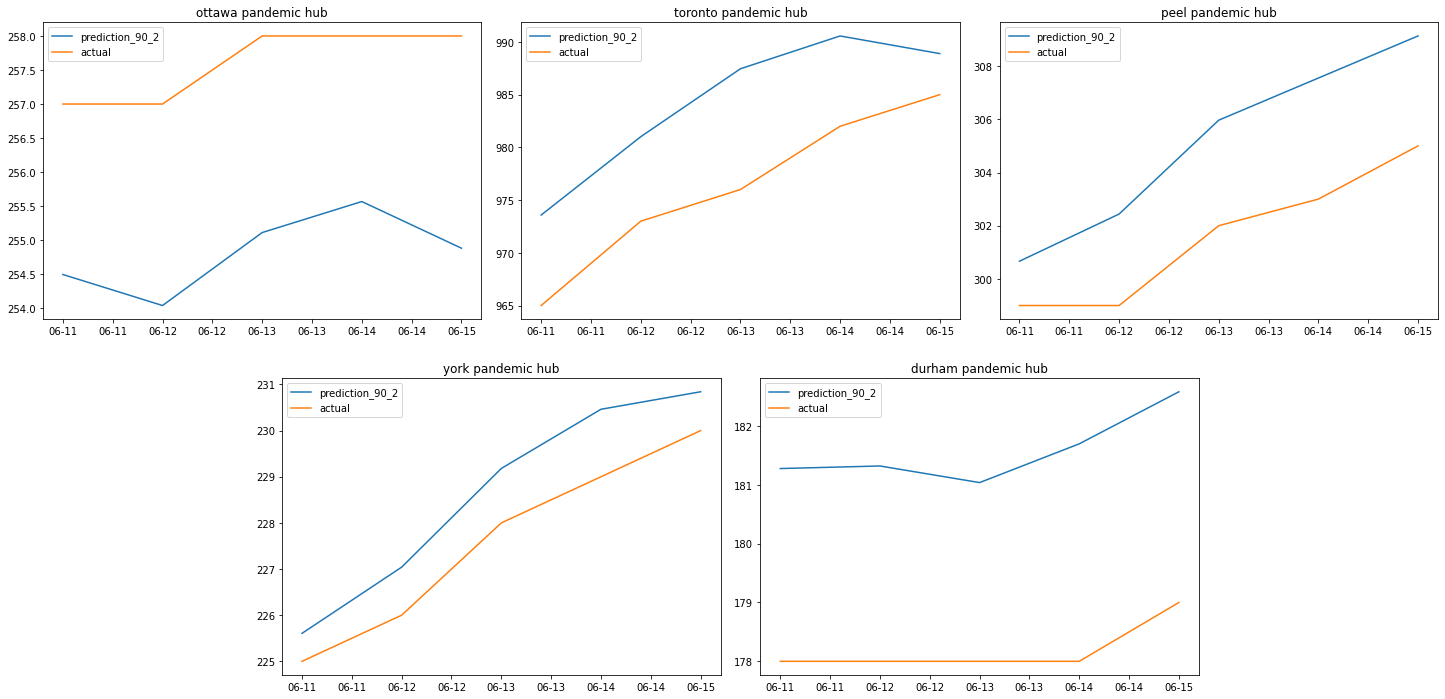

In [68]:

def hr_plot(hr):    
    df_feature, df_label, df_hr1 = df_filter(hr, True,7)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.03, random_state=42, shuffle=False)

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    n_sample = 1
    n_step = X_train.shape[0]
    n_features = X_train.shape[-1]
    x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
    x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(x_test)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_90_2.predict(x_test).flatten()
    
    y_test = Y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('3551')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('ottawa pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3595')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('toronto pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3553')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('peel pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3570')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('york pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3530')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('durham pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
    
    

## Locate the pandemic hub (one)
- ACC metric on training, test, valid set

In [73]:
df_feature, df_label, df_hr1 = df_filter('3530', True,5)
X_train, X_test, y_train, y_test = train_test_split(
                     df_feature, df_label, test_size=0.2, random_state=42, shuffle=False)

Y_train = y_train.to_numpy().reshape(-1,)
Y_test = y_test.to_numpy().reshape(-1,)

n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])

train_pred_60 = model_60.predict_classes(x_train).flatten()
test_pred_60 = model_60.predict_classes(x_test).flatten()

print('ACC score on train:', accuracy_score(train_pred_60, Y_train))
print('ACC score on test:', accuracy_score(test_pred_60, Y_test))


ACC score on train: 0.9849624060150376
ACC score on test: 1.0


## MSE

In [296]:
# not normalized
mean_squared_error(test_inv, inv_90)

8979.686729772482

In [297]:
# normalized
mean_squared_error(Y_test, prediction_90)

1.1945098327133455e-05

## RMSE

In [298]:
# not normalized
mean_squared_error(test_inv, inv_90, squared=False)

94.76120899277554

In [299]:
# normalized
mean_squared_error(Y_test, prediction_90, squared=False)

0.003456168156663309

## Label: scaled_cum_cases

In [100]:
history_90, model_90 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80, model_80 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60, model_60 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)
history_50, model_50 = lstm(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 50)
history_90_2, model_90_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 90)
history_80_2, model_80_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 80)
history_60_2, model_60_2 = lstm_2layer(x_train, Y_train, x_test, Y_test, x_train.shape[1], x_train.shape[-1], 60)

Train on 4454 samples, validate on 170 samples
Epoch 1/50
 - 3s - loss: 1.6761e-04 - mse: 1.6761e-04 - mae: 0.0061 - val_loss: 4.8638e-05 - val_mse: 4.8638e-05 - val_mae: 0.0041
Epoch 2/50
 - 1s - loss: 1.0503e-05 - mse: 1.0503e-05 - mae: 0.0024 - val_loss: 3.2476e-05 - val_mse: 3.2476e-05 - val_mae: 0.0034
Epoch 3/50
 - 1s - loss: 8.7643e-06 - mse: 8.7643e-06 - mae: 0.0022 - val_loss: 2.1675e-05 - val_mse: 2.1675e-05 - val_mae: 0.0026
Epoch 4/50
 - 1s - loss: 7.0605e-06 - mse: 7.0605e-06 - mae: 0.0019 - val_loss: 1.4993e-05 - val_mse: 1.4993e-05 - val_mae: 0.0022
Epoch 5/50
 - 1s - loss: 5.7571e-06 - mse: 5.7571e-06 - mae: 0.0018 - val_loss: 2.3760e-05 - val_mse: 2.3760e-05 - val_mae: 0.0027
Epoch 6/50
 - 1s - loss: 4.2963e-06 - mse: 4.2963e-06 - mae: 0.0015 - val_loss: 3.2400e-05 - val_mse: 3.2400e-05 - val_mae: 0.0031
Epoch 7/50
 - 1s - loss: 3.6522e-06 - mse: 3.6522e-06 - mae: 0.0014 - val_loss: 8.7323e-06 - val_mse: 8.7323e-06 - val_mae: 0.0019
Epoch 8/50
 - 1s - loss: 3.1442e-06 

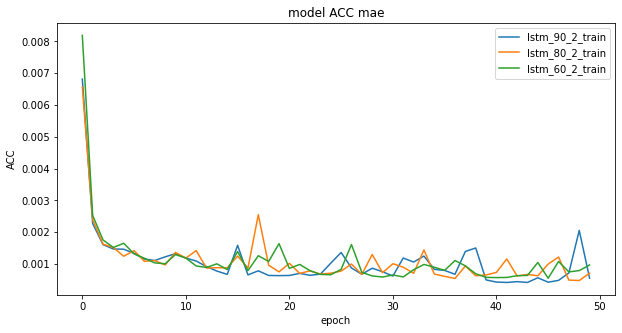

In [101]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90_2.history['mae'])
plt.plot(history_80_2.history['mae'])
plt.plot(history_60_2.history['mae'])

# plt.plot(history.history['val_mae'])
plt.title('model ACC mae')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

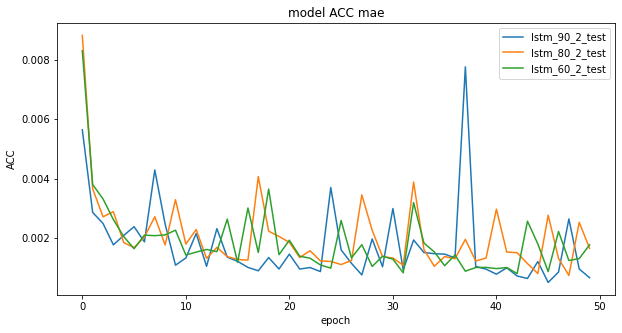

In [102]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90_2.history['val_mae'])
plt.plot(history_80_2.history['val_mae'])
plt.plot(history_60_2.history['val_mae'])

# plt.plot(history.history['val_mae'])
plt.title('model ACC mae')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_test', 'lstm_80_2_test', 'lstm_60_2_test'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

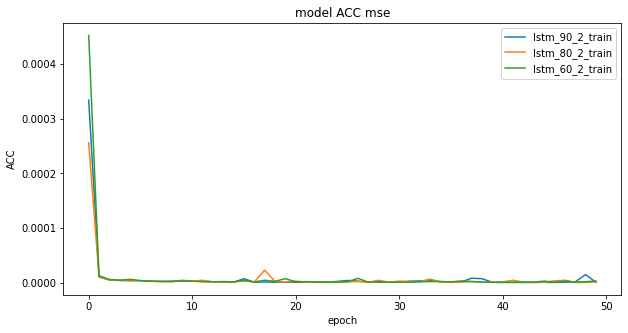

In [103]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90_2.history['mse'])
plt.plot(history_80_2.history['mse'])
plt.plot(history_60_2.history['mse'])

# plt.plot(history.history['val_mae'])
plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_train', 'lstm_80_2_train', 'lstm_60_2_train'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

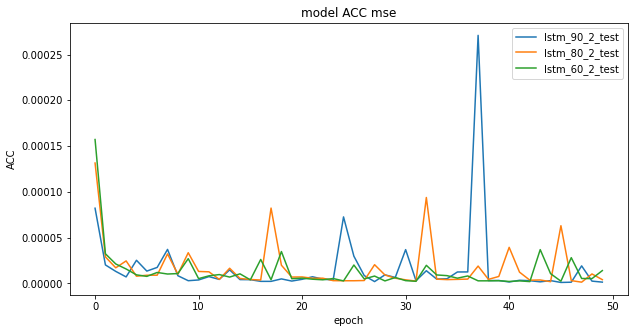

In [104]:
# with lagged 7 features
# summarize hissavetory for accuracy
# plt.plot(history.history['accuracy'])
plt.figure(figsize=(10, 5))
plt.plot(history_90_2.history['val_mse'])
plt.plot(history_80_2.history['val_mse'])
plt.plot(history_60_2.history['val_mse'])

# plt.plot(history.history['val_mae'])
plt.title('model ACC mse')
plt.ylabel('ACC')
plt.xlabel('epoch')
plt.legend(['lstm_90_2_test', 'lstm_80_2_test', 'lstm_60_2_test'], loc='upper right')
# plt.savefig('photo/Multivariate/mae_train_lag.png')
plt.show()

## Output the best LSTM for ON Health Units
- Label: Cumulative death
- LSTM 50

In [106]:
## Run
min_rmse_lst = []

for hr in df_on['HR_UID'].unique().tolist():
    
    df_feature, df_label, df_hr1 = df_filter(hr, True,14)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.03, random_state=42, shuffle=False)
    
    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    n_sample = 1
    n_step = X_train.shape[0]
    n_features = X_train.shape[-1]
    x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
    x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])
    
    prediction_90 = model_90.predict(x_test).flatten()
    prediction_80 = model_80.predict(x_test).flatten()
    prediction_60 = model_60.predict(x_test).flatten()
    prediction_90_2 = model_90_2.predict(x_test).flatten()
    prediction_80_2 = model_80_2.predict(x_test).flatten()
    prediction_60_2 = model_60_2.predict(x_test).flatten()
    
    prediction_90 = prediction_90.reshape(-1, 1)
    prediction_80 = prediction_80.reshape(-1, 1)
    prediction_60 = prediction_60.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    prediction_80_2 = prediction_80_2.reshape(-1, 1)
    prediction_60_2 = prediction_60_2.reshape(-1, 1)
    test_inv = scaler1.inverse_transform(y_test)
    inv_90 = scaler1.inverse_transform(prediction_90)
    inv_80 = scaler1.inverse_transform(prediction_80)
    inv_60 = scaler1.inverse_transform(prediction_60)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    inv_80_2 = scaler1.inverse_transform(prediction_80_2)
    inv_60_2 = scaler1.inverse_transform(prediction_60_2)
    
    rmse_90 = mean_squared_error(test_inv, inv_90, squared=False)
    rmse_80 = mean_squared_error(test_inv, inv_80, squared=False)
    rmse_60 = mean_squared_error(test_inv, inv_60, squared=False)
    rmse_90_2 = mean_squared_error(test_inv, inv_90_2, squared=False)
    rmse_80_2 = mean_squared_error(test_inv, inv_80_2, squared=False)
    rmse_60_2 = mean_squared_error(test_inv, inv_60_2, squared=False)

    result_dict = {}
    result_dict['rmse 90'] = rmse_90
    result_dict['rmse 80'] = rmse_80
    result_dict['rmse 60'] = rmse_60
    result_dict['rmse 90_2'] = rmse_90_2
    result_dict['rmse 80_2'] = rmse_80_2
    result_dict['rmse 60_2'] = rmse_60_2
    
    min_rmse = min(result_dict, key=result_dict.get)
    
    min_rmse_lst.append(min_rmse)
    
def most_frequent(List): 
    counter = 0
    num = List[0] 
      
    for i in List: 
        curr_frequency = List.count(i) 
        if(curr_frequency> counter): 
            counter = curr_frequency 
            num = i 
  
    return num 
  
    
print('The lease rmse from lstm model:',most_frequent(min_rmse_lst))
  

The lease rmse from lstm model: rmse 90_2


## Top 5 pandemic hubs on label cumulative deaths of actual vs predicted val on test set

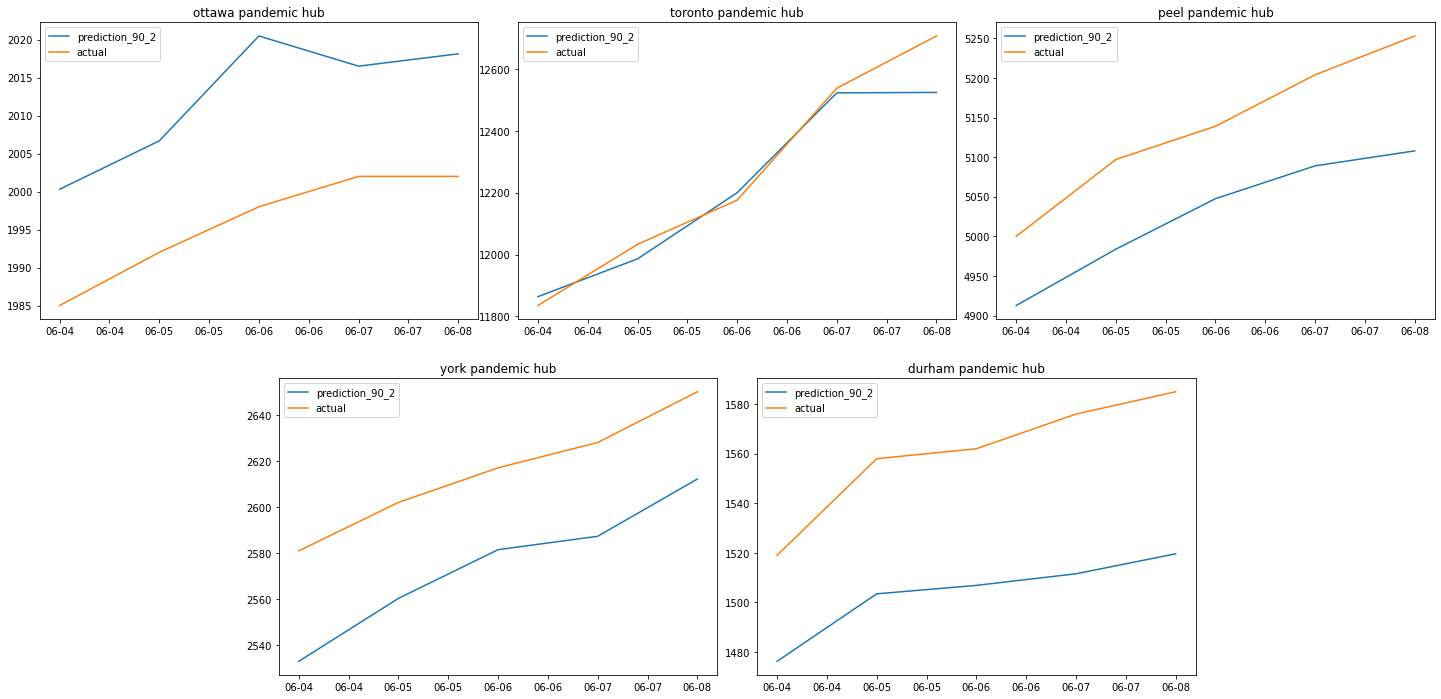

In [108]:

def hr_plot(hr):    
    df_feature, df_label, df_hr1 = df_filter(hr, True,14)
    X_train, X_test, y_train, y_test = train_test_split(
                         df_feature, df_label, test_size=0.03, random_state=42, shuffle=False)

    Y_train = y_train.to_numpy().reshape(-1,)
    Y_test = y_test.to_numpy().reshape(-1,)
    
    n_sample = 1
    n_step = X_train.shape[0]
    n_features = X_train.shape[-1]
    x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
    x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])
    
    then = df_hr1['report_date'].max()

    end_date = datetime.strftime(then + timedelta(1), '%Y-%m-%d')
    date_end_date = datetime.strptime(end_date, '%Y-%m-%d')

    fst_date = datetime.strftime(then - timedelta(len(x_test)-1), '%Y-%m-%d')
    date_fst_date = datetime.strptime(fst_date, '%Y-%m-%d')


    days = mdates.drange(date_fst_date,date_end_date,dt.timedelta(days=1))


    prediction_90_2 = model_90_2.predict(x_test).flatten()
    
    y_test = Y_test.reshape(-1, 1)
    prediction_90_2 = prediction_90_2.reshape(-1, 1)
    
    test_inv = scaler1.inverse_transform(y_test)
    inv_90_2 = scaler1.inverse_transform(prediction_90_2)
    
    return days, test_inv, inv_90_2
    
plt.gcf().set_size_inches(25, 12)  

days, test_inv, inv_90_2 = hr_plot('3551')

plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('ottawa pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3595')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('toronto pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3553')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('peel pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3570')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('york pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
days, test_inv, inv_90_2 = hr_plot('3530')
plt.plot(days,inv_90_2)
plt.plot(days,test_inv)
plt.title('durham pandemic hub')
plt.legend(['prediction_90_2', 'actual'])
    
    

## Locate the pandemic hub (one)

In [129]:
df_feature, df_label, df_hr1 = df_filter('3530', True,14)
X_train, X_test, y_train, y_test = train_test_split(
                     df_feature, df_label, test_size=0.03, random_state=42, shuffle=False)

Y_train = y_train.to_numpy().reshape(-1,)
Y_test = y_test.to_numpy().reshape(-1,)

n_sample = 1
n_step = X_train.shape[0]
n_features = X_train.shape[-1]
x_train = X_train.to_numpy().reshape(n_step, -1,n_features)
x_test = X_test.to_numpy().reshape(X_test.shape[0], -1,X_test.shape[-1])

prediction_90_2 = model_90_2.predict(x_test).flatten()
y_test = Y_test.reshape(-1, 1)
prediction_90_2 = prediction_90_2.reshape(-1, 1)

test_inv = scaler1.inverse_transform(y_test)
inv_90_2 = scaler1.inverse_transform(prediction_90_2)

## MSE

In [130]:
# not normalized
mean_squared_error(test_inv, inv_90_2)

3252.777125775814

In [131]:
# normalized
mean_squared_error(Y_test, prediction_90_2)

4.443189622784908e-06

## RMSE

In [132]:
# not normalized
mean_squared_error(test_inv, inv_90_2, squared=False)

57.033123058235326

In [133]:
# normalized
mean_squared_error(Y_test, prediction_90_2, squared=False)

0.00210788747868213